## Example of likelihood maximization with iMinuit

This notebook contains the basic syntax required to run iMinuit on simulated P1D data

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['savefig.dpi'] = 140
mpl.rcParams['figure.dpi'] = 140
import numpy as np
import time
# our own modules
from lace.archive import gadget_archive
from lace.emulator import gp_emulator
from lace.emulator import nn_emulator
from cup1d.data import data_gadget
from cup1d.likelihood import lya_theory
from cup1d.likelihood import likelihood
from cup1d.likelihood import iminuit_minimizer

### Set up mock data

Begin by picking a simulation to use as mock data, and creating a corresponding data object

In [2]:
# specify simulation to use to generate synthetic data
test_sim_label="central"
if type(test_sim_label)==int:
    drop_sim=test_sim_label
    print('will drop sim number {} from emulator'.format(drop_sim))
else:
    drop_sim=None

In [3]:
# specify simulation suite and P1D mesurements
archive=gadget_archive.GadgetArchive(postproc='Cabayol23')

In [4]:
# add high-k measurement (will change emulator settings as well)
add_hires=False
if add_hires:
    kmax_Mpc=8
    polyfit_ndeg=7
else:
    kmax_Mpc=4
    polyfit_ndeg=5

In [5]:
# specify simulation suite and P1D mesurements
z_max=4.5
data=data_gadget.Gadget_P1D(archive=archive,
                                sim_label="mpg_"+test_sim_label,
                                z_max=z_max,
                                polyfit_kmax_Mpc=kmax_Mpc,
                                polyfit_ndeg=polyfit_ndeg,
                                data_cov_label='Chabanier2019')

In [6]:
# option to add extra P1D (high-resolution)
if add_hires:
    extra_data=data_gadget.Gadget_P1D(archive=archive,
                                sim_label="mpg_"+test_sim_label,
                                z_max=z_max,
                                polyfit_kmax_Mpc=kmax_Mpc,
                                polyfit_ndeg=polyfit_ndeg,
                                data_cov_label='Karacayli2022')
else:
    extra_data=None

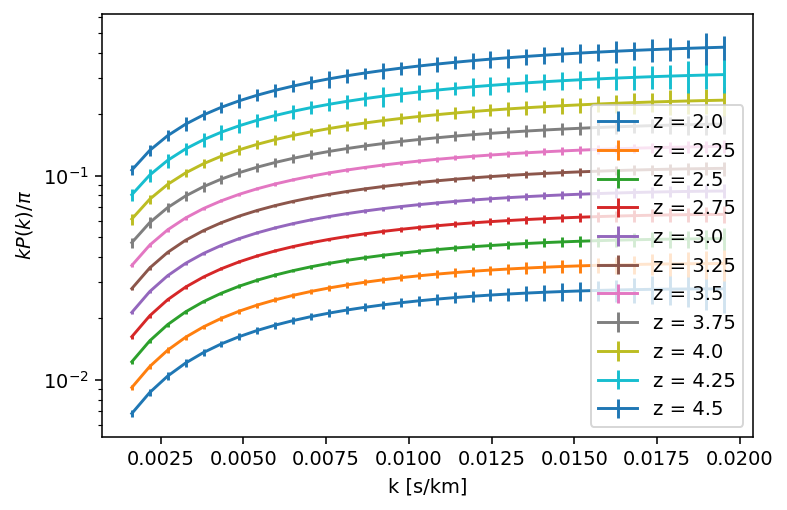

In [7]:
data.plot_p1d()

### Emulator and training set

Create a set of training data to train an emulator

In [8]:
use_gp=True
if use_gp:
    emulator=gp_emulator.GPEmulator(archive=archive,kmax_Mpc=kmax_Mpc,ndeg=polyfit_ndeg)
else:
    nn_emu=nn_emulator.NNEmulator(archive=archive,kmax_Mpc=kmax_Mpc,ndeg=polyfit_ndeg)

Use custom archive provided by the user
Selected custom emulator


 /Users/font/opt/anaconda3/envs/lace_env/lib/python3.8/site-packages/paramz/parameterized.py:61: RuntimeWarning:Don't forget to initialize by self.initialize_parameter()!


Training GP on 330 points
GPs optimised in 0.29 seconds


### Set up a likelihood

Here we chose which parameters we want to sample, over which range and chose a prior. We pass the data and emulator objects to the likelihood.

In [9]:
# stick to primordial power-law parameters here
free_param_names=["As","ns"]
# specify the number of free parameters per IGM function (default=2)
n_igm=1
for i in range(n_igm):
    for par in ["tau","sigT_kms","gamma","kF"]:
        free_param_names.append('ln_{}_{}'.format(par,i))

In [10]:
# option to include/remove a Gaussian prior (in unit cube)
prior_Gauss_rms=None
# option to include/ignore emulator covariance (it might bias the results)
emu_cov_factor=0
like=likelihood.Likelihood(data=data,emulator=emulator,
                            free_param_names=free_param_names,
                            prior_Gauss_rms=prior_Gauss_rms,
                            emu_cov_factor=emu_cov_factor,
                            extra_p1d_data=extra_data)

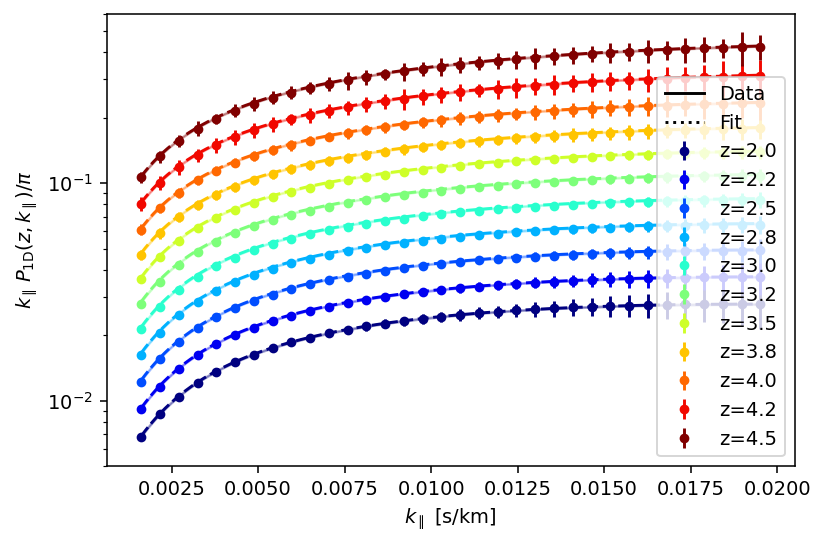

In [11]:
like.plot_p1d(residuals=True,plot_every_iz=2)

In [12]:
if extra_data:
    like.extra_p1d_like.plot_p1d(residuals=True,plot_every_iz=2)

# Try iminuit minimizer

In [13]:
test_values=len(free_param_names)*[0.5]
ini_chi2=like.get_chi2(values=test_values)
print('chi2 =',ini_chi2)

chi2 = 43.8774467385783


In [14]:
minimizer = iminuit_minimizer.IminuitMinimizer(like)

In [16]:
minimizer.minimize(compute_hesse=True)

In [17]:
best_fit_values=np.array(minimizer.minimizer.values)
best_chi2=like.get_chi2(values=best_fit_values)
print('chi2 improved from {} to {}'.format(ini_chi2,best_chi2))

chi2 improved from 43.87744674227141 to 0.27704203518866793


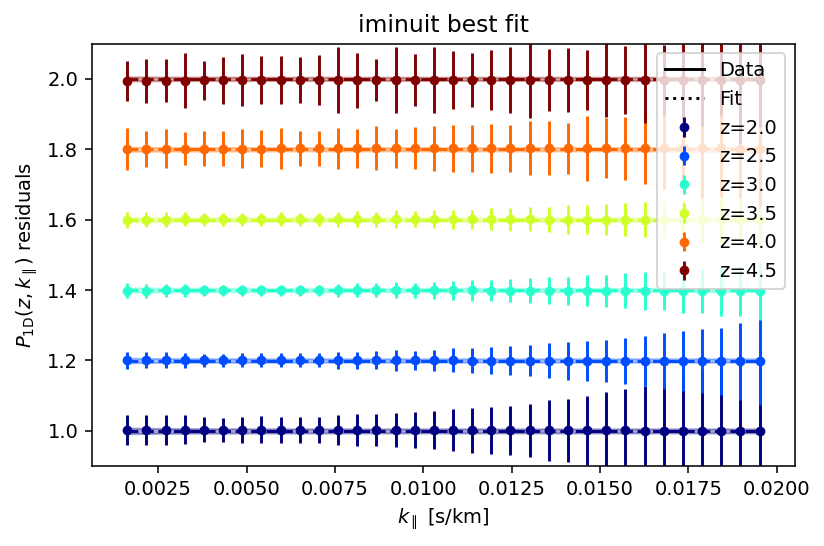

In [18]:
minimizer.plot_best_fit(plot_every_iz=2)

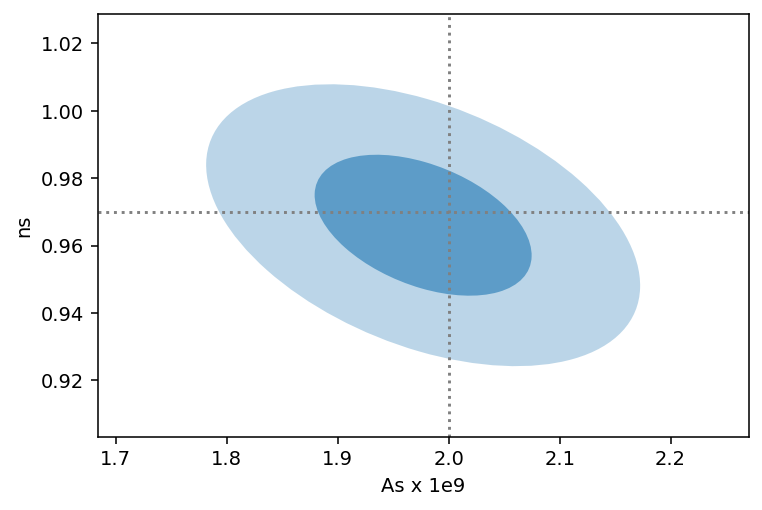

In [19]:
minimizer.plot_ellipses('As','ns')

### Access the actual minimizer object from iminuit

In [20]:
minimizer.minimizer.migrad()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 118.6                      │              Nfcn = 341              │
│ EDM = 1.88e-09 (Goal: 0.0001)    │            time = 8.5 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ x0   │   0.44    │   0.04    │            │            │         │         │       │
│ 1 │ x1   │   0.51    │   0.12    │            │            │         │         │       │
│ 2 │ x2   │   0.56    │   0.29    │            │            │         │         │       │
│ 3 │ x3   │   0.45    │   0.18    │            │            │         │         │       │
│ 4 │ x4   │    0.5    │    0.4    │            │            │         │         │       │
│ 5 │ x5   │   0.47    │   0.29    │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────┬───────────────────────────────────────────────────────┐
│    │       x0       x1       x2       x3       x4       x5 │
├────┼───────────────────────────────────────────────────────┤
│ x0 │  0.00198 -0.00238 -0.00391  0.00111 -0.00333   0.0069 │
│ x1 │ -0.00238   0.0153  0.00348 -0.00648  0.00668  -0.0341 │
│ x2 │ -0.00391  0.00348   0.0847  -0.0496    0.104 -0.00604 │
│ x3 │  0.00111 -0.00648  -0.0496   0.0333   -0.063   0.0114 │
│ x4 │ -0.00333  0.00668    0.104   -0.063    0.134 -0.00929 │
│ x5 │   0.0069  -0.0341 -0.00604   0.0114 -0.00929   0.0873 │
└────┴───────────────────────────────────────────────────────┘

In [21]:
#minimizer.minimizer.draw_mncontour("x0", "x1")

In [22]:
#minimizer.minimizer.draw_mnprofile("x0")